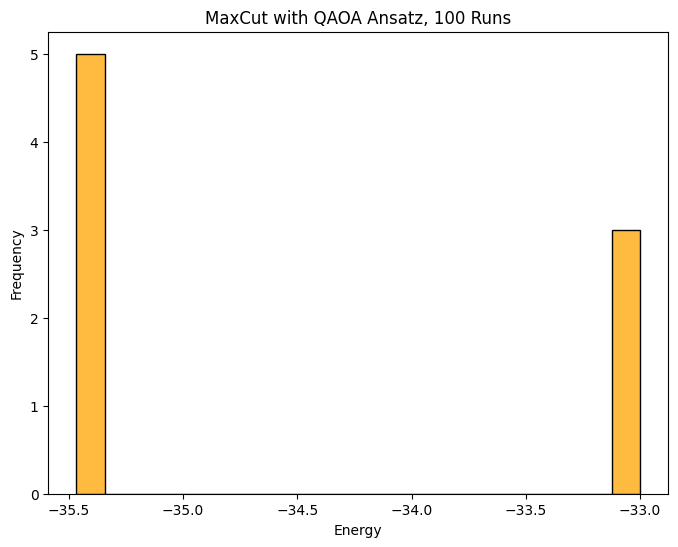

Lowest energy achieved: -35.467509


In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Pauli
import networkx as nx
import numpy as np
from scipy.optimize import minimize
from qiskit.primitives import Estimator
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

# QAOA Ansatz
def qaoa_ansatz(num_qubits, p):
    graph = nx.complete_graph(num_qubits)
    qc = QuantumCircuit(num_qubits)
    beta = [Parameter(f'β{i}') for i in range(p)]
    gamma = [Parameter(f'γ{i}') for i in range(p)]
    qc.h(range(num_qubits))  # Initialize in |+>
    for i in range(p):
        for u, v in graph.edges:
            qc.rzz(2 * gamma[i], u, v)  # Cost Hamiltonian
        qc.rx(2 * beta[i], range(num_qubits))  # Mixer
    return qc, beta + gamma

# MaxCut Hamiltonian
def maxcut_hamiltonian(graph, num_qubits):
    paulis = []
    coeffs = []
    for u, v in graph.edges:
        pauli_str = ['I'] * num_qubits
        pauli_str[u] = 'Z'
        pauli_str[v] = 'Z'
        paulis.append(Pauli("".join(pauli_str)))
        coeffs.append(0.5)
        paulis.append(Pauli("I" * num_qubits))
        coeffs.append(-0.5)
    return SparsePauliOp(paulis, coeffs)

# Cost function
def cost_function(params, ansatz, hamiltonian, num_qubits, p):
    qc, theta = ansatz(num_qubits, p)
    param_dict = {theta[i]: params[i] for i in range(len(theta))}
    bound_circuit = qc.assign_parameters(param_dict)
    estimator = Estimator()
    result = estimator.run(bound_circuit, [hamiltonian])
    return result.result().values[0]

# Optimization loop with timeout
def optimization_loop_with_timeout(hamiltonian, num_qubits, p, optimizer, initial_params, timeout=30):
    start_time = time.time()
    def cost(params):
        return cost_function(params, qaoa_ansatz, hamiltonian, num_qubits, p)
    result = None
    try:
        result = minimize(
            cost,
            initial_params,
            method=optimizer,
            options={'maxiter': 500, 'tol': 1e-6},
            callback=lambda xk: (time.time() - start_time) < timeout,
        )
    except Exception as e:
        print(f"Optimization failed: {e}")
    if result and result.success:
        final_energy = cost_function(result.x, qaoa_ansatz, hamiltonian, num_qubits, p)
        return final_energy, result.x
    else:
        return None, None

# Parallel optimization runs
def run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, p, optimizer, timeout=30):
    energies = []
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                optimization_loop_with_timeout,
                hamiltonian,
                num_qubits,
                p,
                optimizer,
                np.random.uniform(0, 2 * np.pi, 2 * p),
                timeout,
            )
            for _ in range(num_runs)
        ]
        for future in as_completed(futures):
            optimal_value, optimal_params = future.result()
            if optimal_value is not None:
                recalculated_energy = cost_function(optimal_params, qaoa_ansatz, hamiltonian, num_qubits, p)
                energies.append(recalculated_energy)
    return energies

# Problem setup
num_qubits = 12
p = 1
graph = nx.complete_graph(num_qubits)
hamiltonian = maxcut_hamiltonian(graph, num_qubits)
optimizer = 'COBYLA'
num_runs = 10
timeout = 30

# Perform parallel optimization
energies = run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, p, optimizer, timeout)

# Plot results
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='orange')
plt.title('MaxCut with QAOA Ansatz, 100 Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

# Print the best energy achieved
if energies:
    print(f'Lowest energy achieved: {min(energies):.6f}')
else:
    print("No successful optimizations.")
